In [ ]:
!git clone "https://github.com/aminul-huq/Speech-Command-Classification.git"

Cloning into 'Speech-Command-Classification'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 15 (delta 3), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (15/15), done.


In [ ]:
%cd Speech-Command-Classification/

/content/Speech-Command-Classification


In [ ]:
%mkdir "data1"

In [ ]:
import os, warnings
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,random_split,Dataset
import torchaudio
from torchaudio import transforms
from torch import Tensor

# from torchaudio.datasets.utils import (
#     download_url,
#     extract_archive,
#     walk_files
# )

from train_utils import *
from model import *
from dataloader import *

In [ ]:
dataset = torchaudio.datasets.SPEECHCOMMANDS('./data1/' , url = 'speech_commands_v0.02', folder_in_archive= 'SpeechCommands',  download = True)

  0%|          | 0.00/2.26G [00:00<?, ?B/s]

In [ ]:
train_audio_path = './data1/SpeechCommands/speech_commands_v0.02/'

labels_dict=os.listdir(train_audio_path)

a = torchaudio.datasets.SPEECHCOMMANDS('./data1/' , url = 'speech_commands_v0.02', 
                                       folder_in_archive= 'SpeechCommands', download = True)

Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


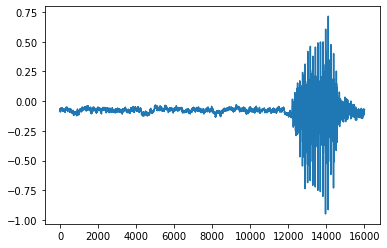

In [ ]:
filename = "./data1/SpeechCommands/speech_commands_v0.02/backward/0165e0e8_nohash_0.wav"
waveform, sample_rate = torchaudio.load(filename)

print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.figure()
plt.plot(waveform.t().numpy())

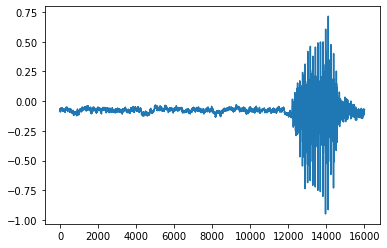

In [ ]:
plt.plot(a[0][0].t())
plt.show()

In [ ]:
from tqdm import tqdm

In [ ]:
count=0
wave = []
labels = []
for i in tqdm(range(0,105829)):
    if a[i][0].shape == (1,16000):
        wave.append(a[i][0])
        labels.append(a[i][2])

100%|██████████| 105829/105829 [01:36<00:00, 1092.17it/s]


Shape of spectrogram: torch.Size([1, 40, 81])


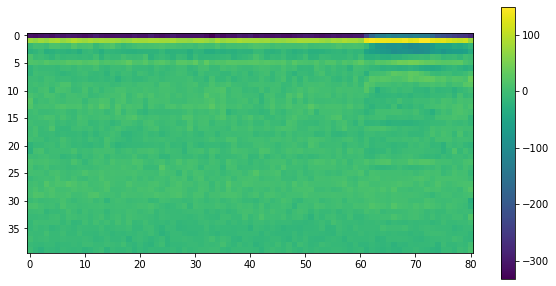

In [ ]:
specgram = torchaudio.transforms.MFCC()(wave[0])

print("Shape of spectrogram: {}".format(specgram.size()))

plt.figure(figsize=(10,5))
plt.imshow(specgram[0,:,:].numpy())
plt.colorbar()
plt.show()

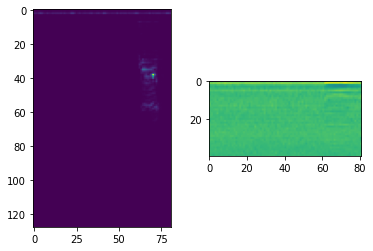

In [ ]:
specgram = torchaudio.transforms.MelSpectrogram()(wave[0])
mfcc = torchaudio.transforms.MFCC()(wave[0])


fig,ax = plt.subplots(1,2)

ax[0].imshow(specgram[0,:,:].numpy())
ax[1].imshow(mfcc[0,:,:].numpy())

In [ ]:
data_transform = 1

if data_transform == 1:
    print("MFCC Features classification")
    train_audio_transforms = nn.Sequential(
            torchaudio.transforms.MFCC(log_mels=False)
            )
    net = NN2D(num_class=35)
elif data_transform == 2:
    print("Mel Spectogram Features classification")
    train_audio_transforms = nn.Sequential(
            torchaudio.transforms.MelSpectrogram()
            )
    net = NN2DMEL(num_class=35)
else:
    train_audio_transforms = None
    net = NN(num_class=35)

MFCC Features classification


In [ ]:
dataset= SpeechDataLoader(wave,labels,labels_dict, train_audio_transforms)

traindata, testdata = random_split(dataset, [round(len(dataset)*.8), round(len(dataset)*.2)])

trainloader = torch.utils.data.DataLoader(traindata, batch_size=100, shuffle=True)

testloader = torch.utils.data.DataLoader(testdata, batch_size=100, shuffle=True)

In [ ]:
t=[]
for input,output in tqdm(trainloader):
    for i in output.tolist():
      t.append(i)

100%|██████████| 764/764 [00:44<00:00, 17.34it/s]


In [ ]:
s=set(t)
print(len(s))

35


In [ ]:
s1=list(s)

In [ ]:
s1.sort()

In [ ]:
print(s1)

[0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 36, 37, 39, 40]


In [ ]:
label_mapping={}

for i in range(len(s)):
    label_mapping[s1[i]]=i

In [ ]:
label_mapping

{0: 0,
 2: 1,
 3: 2,
 4: 3,
 5: 4,
 6: 5,
 7: 6,
 8: 7,
 10: 8,
 11: 9,
 12: 10,
 13: 11,
 14: 12,
 15: 13,
 16: 14,
 18: 15,
 19: 16,
 20: 17,
 21: 18,
 22: 19,
 23: 20,
 24: 21,
 25: 22,
 26: 23,
 27: 24,
 28: 25,
 29: 26,
 30: 27,
 31: 28,
 32: 29,
 33: 30,
 36: 31,
 37: 32,
 39: 33,
 40: 34}

In [ ]:
s

{0,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 36,
 37,
 39,
 40}

In [ ]:
#device="cpu"

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net = net.to(device)

cpu


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(),lr=0.001)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                              steps_per_epoch=int(len(trainloader)),
                                              epochs=20,
                                              anneal_strategy='linear') 


In [ ]:
import torch,os
from tqdm import tqdm
import torch.optim as optim


best_acc=0

def train_(net,trainloader,optim,scheduler,criterion,epoch,device):
    print("Training..")
    net.train()
    train_loss = 0
    total = 0
    total_correct = 0
    iterator = tqdm(trainloader)
    for inputs,targets in iterator:
        inputs,targets = inputs.to(device), targets.to(device)
        optim.zero_grad()
        outputs = net(inputs)
        #import pdb; pdb.set_trace()
        targets=targets.tolist()
        for i in range(len(targets)):
            targets[i]=label_mapping[targets[i]]
        targets=torch.tensor(targets)
        loss = criterion(outputs,targets)
        loss.backward()
        #optim.step()
        scheduler.step()
        
        train_loss += loss.item()
        _,predicted = torch.max(outputs.data,1)
        total_correct += (predicted == targets).sum().item()
        total += targets.size(0)
    
    print("Epoch: [{}]  loss: [{:.2f}] Accuracy [{:.2f}] ".format(epoch+1,train_loss/len(trainloader),
                                                                           total_correct*100/total))
    
def test_(net,testloader,optim,criterion,epoch,device,model_name):
    global best_acc
    print("validation")
    net.eval()
    test_loss,total,total_correct = 0,0,0
    
    iterator = tqdm(testloader)
    
    for inputs, targets in iterator:
        
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = net(inputs)
        targets=targets.tolist()
        for i in range(len(targets)):
            targets[i]=label_mapping[targets[i]]
        targets=torch.tensor(targets)
        loss = criterion(outputs, targets)

        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        total_correct += (predicted == targets).sum().item()

    # Save checkpoint when best model
    acc = 100. * total_correct / total
    print("\nValidation Epoch #%d\t\t\tLoss: %.4f Acc@1: %.2f%%" %(epoch+1, test_loss/len(testloader), acc))

    # f = open(results_txt+".txt","a+")
    # f.write("Validation Epoch #%d\t\t\tLoss: %.4f Acc@1: %.2f%% \n" %(epoch+1, test_loss/len(testloader), acc))
    # f.close() 
        
    
    if acc > best_acc:
        
        
        if isinstance(net, torch.nn.DataParallel):
            print("multiple GPU")
            print('Saving Best model...\t\t\tTop1 = %.2f%%' %(acc))
            state = {
                'model':net.module.state_dict(),
                'model1': net.state_dict(),
                'model2': net,
                'acc':acc,
                'epoch':epoch,
            }
        
        else:
            print("not multiple GPU")
            state = {
                    'model':net,
                    'acc':acc,
                    'epoch':epoch,
                    }      
            
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        save_point = './checkpoint/'
        if not os.path.isdir(save_point):
            os.mkdir(save_point)
        torch.save(state, save_point+model_name+'.t7')
        best_acc = acc
        
    return best_acc

In [ ]:
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
num_epochs=20

for epoch in range(num_epochs):    
    train_(net,trainloader,optimizer,scheduler,criterion,epoch,device)
    best_acc = test_(net,testloader,optimizer,criterion,epoch,device,'SC')

Training..


100%|██████████| 764/764 [01:32<00:00,  8.24it/s]


Epoch: [1]  loss: [1.56] Accuracy [53.70] 
validation


100%|██████████| 191/191 [00:15<00:00, 12.24it/s]



Validation Epoch #1			Loss: 1.2185 Acc@1: 68.97%
not multiple GPU
Training..


100%|██████████| 764/764 [01:23<00:00,  9.11it/s]


Epoch: [2]  loss: [1.57] Accuracy [53.38] 
validation


100%|██████████| 191/191 [00:14<00:00, 12.81it/s]



Validation Epoch #2			Loss: 1.2184 Acc@1: 68.97%
Training..


100%|██████████| 764/764 [01:26<00:00,  8.88it/s]


Epoch: [3]  loss: [1.57] Accuracy [53.39] 
validation


100%|██████████| 191/191 [00:14<00:00, 12.84it/s]



Validation Epoch #3			Loss: 1.2187 Acc@1: 68.97%
Training..


100%|██████████| 764/764 [01:24<00:00,  9.03it/s]


Epoch: [4]  loss: [1.57] Accuracy [53.40] 
validation


100%|██████████| 191/191 [00:15<00:00, 12.06it/s]



Validation Epoch #4			Loss: 1.2187 Acc@1: 68.97%
Training..


100%|██████████| 764/764 [01:25<00:00,  8.90it/s]


Epoch: [5]  loss: [1.57] Accuracy [53.50] 
validation


100%|██████████| 191/191 [00:15<00:00, 12.62it/s]



Validation Epoch #5			Loss: 1.2185 Acc@1: 68.97%
Training..


100%|██████████| 764/764 [01:23<00:00,  9.19it/s]


Epoch: [6]  loss: [1.57] Accuracy [53.42] 
validation


100%|██████████| 191/191 [00:15<00:00, 12.49it/s]



Validation Epoch #6			Loss: 1.2185 Acc@1: 68.97%
Training..


100%|██████████| 764/764 [01:23<00:00,  9.13it/s]


Epoch: [7]  loss: [1.57] Accuracy [53.48] 
validation


100%|██████████| 191/191 [00:14<00:00, 12.74it/s]



Validation Epoch #7			Loss: 1.2184 Acc@1: 68.97%
Training..


100%|██████████| 764/764 [01:22<00:00,  9.27it/s]


Epoch: [8]  loss: [1.57] Accuracy [52.98] 
validation


100%|██████████| 191/191 [00:14<00:00, 12.79it/s]



Validation Epoch #8			Loss: 1.2186 Acc@1: 68.97%
Training..


100%|██████████| 764/764 [01:22<00:00,  9.24it/s]


Epoch: [9]  loss: [1.57] Accuracy [53.46] 
validation


100%|██████████| 191/191 [00:14<00:00, 12.77it/s]



Validation Epoch #9			Loss: 1.2185 Acc@1: 68.97%
Training..


100%|██████████| 764/764 [01:21<00:00,  9.32it/s]


Epoch: [10]  loss: [1.56] Accuracy [53.47] 
validation


100%|██████████| 191/191 [00:14<00:00, 13.01it/s]



Validation Epoch #10			Loss: 1.2186 Acc@1: 68.97%
Training..


100%|██████████| 764/764 [01:21<00:00,  9.33it/s]


Epoch: [11]  loss: [1.57] Accuracy [53.28] 
validation


100%|██████████| 191/191 [00:14<00:00, 12.95it/s]



Validation Epoch #11			Loss: 1.2186 Acc@1: 68.97%
Training..


100%|██████████| 764/764 [01:22<00:00,  9.25it/s]


Epoch: [12]  loss: [1.56] Accuracy [53.52] 
validation


100%|██████████| 191/191 [00:15<00:00, 12.71it/s]



Validation Epoch #12			Loss: 1.2185 Acc@1: 68.97%
Training..


100%|██████████| 764/764 [01:22<00:00,  9.24it/s]


Epoch: [13]  loss: [1.57] Accuracy [53.56] 
validation


100%|██████████| 191/191 [00:14<00:00, 13.00it/s]



Validation Epoch #13			Loss: 1.2187 Acc@1: 68.97%
Training..


100%|██████████| 764/764 [01:22<00:00,  9.21it/s]


Epoch: [14]  loss: [1.57] Accuracy [53.52] 
validation


100%|██████████| 191/191 [00:14<00:00, 13.03it/s]



Validation Epoch #14			Loss: 1.2187 Acc@1: 68.97%
Training..


100%|██████████| 764/764 [01:22<00:00,  9.31it/s]


Epoch: [15]  loss: [1.57] Accuracy [53.33] 
validation


100%|██████████| 191/191 [00:15<00:00, 12.70it/s]



Validation Epoch #15			Loss: 1.2185 Acc@1: 68.97%
Training..


100%|██████████| 764/764 [01:23<00:00,  9.10it/s]


Epoch: [16]  loss: [1.57] Accuracy [53.40] 
validation


100%|██████████| 191/191 [00:14<00:00, 12.89it/s]



Validation Epoch #16			Loss: 1.2184 Acc@1: 68.97%
Training..


100%|██████████| 764/764 [01:23<00:00,  9.12it/s]


Epoch: [17]  loss: [1.57] Accuracy [53.45] 
validation


100%|██████████| 191/191 [00:14<00:00, 13.11it/s]



Validation Epoch #17			Loss: 1.2186 Acc@1: 68.97%
Training..


100%|██████████| 764/764 [01:22<00:00,  9.25it/s]


Epoch: [18]  loss: [1.57] Accuracy [53.52] 
validation


100%|██████████| 191/191 [00:14<00:00, 12.96it/s]



Validation Epoch #18			Loss: 1.2188 Acc@1: 68.97%
Training..


100%|██████████| 764/764 [01:23<00:00,  9.20it/s]


Epoch: [19]  loss: [1.57] Accuracy [53.09] 
validation


100%|██████████| 191/191 [00:15<00:00, 12.70it/s]



Validation Epoch #19			Loss: 1.2184 Acc@1: 68.97%
Training..


100%|██████████| 764/764 [01:22<00:00,  9.27it/s]


Epoch: [20]  loss: [1.57] Accuracy [53.49] 
validation


100%|██████████| 191/191 [00:15<00:00, 12.59it/s]


Validation Epoch #20			Loss: 1.2185 Acc@1: 68.97%
